# Produce two and three knock-downs recommendations

This notebook explains how to produce recommendations for knockdown of two and three genes for the CRISPRi project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

## Setup

### Imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### User parameters

In [2]:
user_params = {
    'output_dir'  : './results',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/David Carruthers sample injection order.xlsx'
}

In [3]:
ls

check_original_prot_map.ipynb  DBTL1Recs4David_plotupdates.ipynb
choose_targets_sandbox.ipynb   get_Pputida_uniprot.ipynb
data/                          get_Pputida_unreviewed_uniprot.ipynb
DBTL1Recs4David.ipynb          results/
DBTL1Recs4David_local.ipynb    test_normalize.ipynb


### Useful functions

In [4]:
def create_strain_names(df: pd.DataFrame):
    "Creates strain names by reading Line Description and eliminating Biolector culture info."
    strains = [
        line_name.split('_')[1] for line_name in df["Line Description"].to_list()
    ]
    return strains

In [5]:
def find_library_stats(df):
    """Find mean, std and quartiles of the target transcription level from the whole library excluding the target strain"""
    
    stat_names = ['Library_mean', 'Library_std', 'Library_Q1', 'Library_Q3']
    for n in stat_names:
        df.loc[n] = None
        df.loc[n].astype('float64')

    no_data =[]
    for target in df['Target'].dropna():
        if target in df_targets.columns:
            # Exclude the target strain from the mean
            ind = df.index[df['Target']==target].tolist()       
            ind.extend(stat_names)

            mean = df.drop(index=ind)[target].mean()
            df.loc['Library_mean', target] = mean

            std = df.drop(index=ind)[target].std()
            df.loc['Library_std', target] = std

            q1 = df.drop(index=ind)[target].quantile(.25)
            q3 = df.drop(index=ind)[target].quantile(.75)
            df.loc['Library_Q1', target] = q1
            df.loc['Library_Q3', target] = q3
        else:
            #no_data.append((df_targets[df_targets.loc[:,"Target"]==target].index.tolist(),target))
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
            
        
    return df

In [6]:
def find_fold_changes(df):
    """Find fold changes of the transcription in the targeted strain vs library"""
    
    col_names = [
        'Target:Control', 
        'Target:Library_mean', 
        'Target:Library_Q1', 
        'Target:Library_Q3',
        'Z-score'
    ]
    df[col_names] = None

    no_data = []
    for target in df['Target'].dropna():
        if target in df.columns:
            ind = df.index[df['Target']==target][0]

            df.loc[
                ind, 'Target:Control'
            ] = df.loc[ind, target] / df.loc[control_strain, target]

            mean = df.loc['Library_mean'][target]
            std = df.loc['Library_std'][target]

            df.loc[
                ind, 'Target:Library_mean'
            ] = df.loc[ind, target] / mean

            df.loc[
                ind, 'Target:Library_Q1'
            ] = df.loc[ind, target] / df.loc['Library_Q1'][target]
            df.loc[
                ind, 'Target:Library_Q3'
            ] = df.loc[ind, target] / df.loc['Library_Q3'][target]

            df.loc[
                ind, 'Z-score'
            ] = (df.loc[ind, target] - mean) / std
        else:
            no_data.append(target)
            
    print("Data for these "+str(len(no_data))+" proteins was not present:")
    print(no_data)
    
    return df
    

## Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [7]:
study_slug_1 = 'crispri-automation-for-isoprenol-production-in-p-p'
edd_server   = 'edd.jbei.org'
username     = 'pckinnunen'


We try connecting to the server with our login and password:

In [8]:
try:
    session = eddu.login(edd_server=edd_server, user=username)
except:
    print('ERROR! Connection to EDD failed. We will try to load data from disk...')
else:
    print('OK! Connection to EDD successful. We will try to load data from EDD...')

Password for pckinnunen:  ········


OK! Connection to EDD successful. We will try to load data from EDD...


And then we try to export the study from the EDD instance:

In [9]:
try:
    df = eddu.export_study(session, study_slug_1, edd_server=edd_server)
except (NameError, AttributeError, KeyError):
    print(f'ERROR! Not able to export the study.')

100%|██████████| 1182270/1182270 [01:06<00:00, 17657.92it/s]


There are lots of data here (particularly the biolector data takes a lot of space):

Let's have a look at the different protocols (types of data) that are includeed in the study:

In [10]:
df['Protocol'].unique()

array(['Biolector', 'GC-FID', 'Global Proteomics'], dtype=object)

## Preprocess and inspect data

### Eliminate biolector data

For our current purposes, we don't need the biolector data, so let's get rid of it (we can always recover it later):

In [11]:
df['Protocol']=='Biolector'

0           True
1           True
2           True
3           True
4           True
           ...  
1182265    False
1182266    False
1182267    False
1182268    False
1182269    False
Name: Protocol, Length: 1182270, dtype: bool

In [12]:
df2 = df.loc[df['Protocol']!='Biolector']

And we still have over a million entries of data:

In [13]:
df2.shape

(1033140, 15)

Let's just keep the basic data types:

In [14]:
df2 = df2.loc[:,['Line Name', 'Line Description', 'Protocol','Formal Type', 'Measurement Type', 'Value']]

Let's have a look a the lines we have here:

In [15]:
line_desc = df2['Line Description'].unique()
len(line_desc), line_desc

(420,
 array(['BL1A2_IY1586', 'BL1A3_IY1587', 'BL1A4_IY1588', 'BL1A5_IY1589',
        'BL1A6_IY1590', 'BL1A7_IY1591', 'BL1A8_IY1592', 'BL1B2_IY1586',
        'BL1B3_IY1587', 'BL1B4_IY1588', 'BL1B5_IY1589', 'BL1B6_IY1590',
        'BL1B7_IY1591', 'BL1B8_IY1592', 'BL1C2_IY1586', 'BL1C3_IY1587',
        'BL1C4_IY1588', 'BL1C5_IY1589', 'BL1C6_IY1590', 'BL1C7_IY1591',
        'BL1C8_IY1592', 'BL1D1_IY1593', 'BL1D2_IY1594', 'BL1D3_IY1595',
        'BL1D4_IY1596', 'BL1D5_IY1597', 'BL1D6_IY1452_pIY1081',
        '**BL1D7_IY1655', '**BL1D8_IY1656', '**BL1E1_IY1593',
        '**BL1E2_IY1594', '**BL1E3_IY1595', 'BL1E4_IY1596', 'BL1E5_IY1597',
        'BL1E6_IY1452_pIY1081', 'BL1E7_IY1655', 'BL1E8_IY1656',
        'BL1F1_IY1593', 'BL1F2_IY1594', 'BL1F3_IY1595', 'BL1F4_IY1596',
        'BL1F5_IY1597', 'BL1F6_IY1452_pIY1081', 'BL1F7_IY1655',
        'BL1F8_IY1656', 'BL2A2_IY1452_pIY1079', 'BL2A3_IY1452_pIY1080',
        'BL2A4_IY1657', 'BL2A5_IY1658', 'BL2A6_IY1659', 'BL2A7_IY1660',
        'BL2A8_I

In [16]:
line_name = df2['Line Name'].unique()
len(line_name), line_name

(420,
 array(['PP_4549-R1', 'PP_4550-R1', 'PP_0368-R1', 'PP_2136-R1',
        'PP_0774-R1', 'PP_0362-R1', 'PP_0437-R1', 'PP_4549-R2',
        'PP_4550-R2', 'PP_0368-R2', 'PP_2136-R2', 'PP_0774-R2',
        'PP_0362-R2', 'PP_0437-R2', 'PP_4549-R3', 'PP_4550-R3',
        'PP_0368-R3', 'PP_2136-R3', 'PP_0774-R3', 'PP_0362-R3',
        'PP_0437-R3', 'PP_2589-R1', 'PP_3744-R1', 'PP_4194_NT2-R1',
        'PP_4194_NT3-R1', 'PP_1607_NT1-R1', 'PP_1607_NT4-R1',
        'PP_1607_NT1_xylS_Pm-R1', 'PP_1607_NT2_xylS_Pm-R1', 'PP_2589-R2',
        'PP_3744-R2', 'PP_4194_NT2-R2', 'PP_4194_NT3-R2', 'PP_1607_NT1-R2',
        'PP_1607_NT4-R2', 'PP_1607_NT1_xylS_Pm-R2',
        'PP_1607_NT2_xylS_Pm-R2', 'PP_2589-R3', 'PP_3744-R3',
        'PP_4194_NT2-R3', 'PP_4194_NT3-R3', 'PP_1607_NT1-R3',
        'PP_1607_NT4-R3', 'PP_1607_NT1_xylS_Pm-R3',
        'PP_1607_NT2_xylS_Pm-R3', 'PP_1607_NT2-R1', 'PP_1607_NT3-R1',
        'PP_1607_NT3_xylS_Pm-R1', 'PP_1607_NT4_xylS_Pm-R1', 'PP_1444-R1',
        'PP_0338-R1', 

In [17]:
df2['Formal Type'].unique()

array(['cid:12988', 'sp|O85207|PHAG_PSEPK Phag',
       'sp|P00552|KKA2_KLEPN Neo', ..., 'sp|Q88RM6|Q88RM6_PSEPK Pp_0103',
       'sp|Q88RS8|Q88RS8_PSEPK Pp_0051', 'sp|Q88RV6|Q88RV6_PSEPK Pp_0023'],
      dtype=object)

In [18]:
df2['Protocol'].unique()

array(['GC-FID', 'Global Proteomics'], dtype=object)

In [19]:
df2[df2['Protocol']=='GC-FID']['Measurement Type'].unique()

array(['3-METHYL-3-BUTEN-1-OL'], dtype=object)

In [20]:
df2

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.989604e+02
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,1.673975e+02
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.405714e+02
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,3.485097e+02
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,2.151588e+02
...,...,...,...,...,...,...
1182265,PP_5416-R2,BL10B5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,1.051687e+06
1182266,PP_5416-R3,BL10C5_IY2022,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,9.921411e+05
1182267,PP_5420-R1,BL10A4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,5.949145e+05
1182268,PP_5420-R2,BL10B4_IY2019,Global Proteomics,sp|Q9Z408|CSD_PSEPK Csda,Probable cysteine desulfurase,3.865737e+05


In [21]:
df2.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588


## Normalize based on sample run time

1. Check to make sure each entry in df2['Line Name'] matches an entry in the order spreadsheet
2. Pull out controls from each day
3. Get rid of proteins missing from controls
4. Normalize each run by control mean
5. Compare the distributions of normalized and unnormalized proteins


### 1. Check correspondence between lists of line names.

Import order of runs.

In [22]:
df_order = pd.read_excel(user_params['run_list'])
df_order.head()
#make a sample->day dictionary
batch_day_dict = dict(df_order.values)

Check that sample names match between EDD and spreadsheet

In [23]:
unique_sample_names_order = df_order['Sample Name in order injected'].unique().sort()
unique_sample_names_df2 = df2['Line Name'].unique().sort()
print(f'Sorted, unique names are identical: {"Yes" if unique_sample_names_df2 == unique_sample_names_order else "No"}')
assert unique_sample_names_df2 == unique_sample_names_order, "ERROR: sample names don't match in spreadsheets."


Sorted, unique names are identical: Yes


### 2. Pull out controls and look at distributions of proteomics

We find the control strains by looking for the 'ontrol' string in the line name (using instead of 'Control' or 'control' to avoid capitalization issues), and we add the information as a new column:

In [24]:
find_control   = lambda x: True if 'ontrol' in x else False 
df2['Control'] =  df2['Line Name'].apply(find_control)
df_control = df2[df2['Control']].copy()

Find day each experiment was conducted and add to dataframe.

In [25]:
find_expt_day = lambda x: batch_day_dict[x]
df_control['Batch number'] = df_control['Line Name'].apply(find_expt_day)

Print the day for each control - they aren't uniformly distributed.

In [26]:
for ii in range(1,4):
    print(f'Controls on day {ii}: {df_control[df_control["Batch number"] == ii]["Line Name"].unique()}')

Controls on day 1: ['Control-R1' 'Control-R2' 'Control-R3' 'Control-R4' 'Control-R5'
 'Control-R6' 'Control-R7']
Controls on day 2: ['Control-R8' 'Control-R9' 'Control-R10' 'Control-R11' 'Control-R12'
 'Control-R13' 'Control-R14']
Controls on day 3: ['Control-R15' 'Control-R16' 'Control-R17' 'Control-R18']


### 3. Check for proteins missing from each day and drop them

Check how many different analytes are measured in controls.

In [27]:
print(f'There are {len(df_control["Measurement Type"].unique())} unique analytes in the control dataframe')

There are 2005 unique analytes in the control dataframe


Create pivot table based on batch number. 

In [28]:
cntrl_pivot_by_measurement = pd.pivot_table(df_control, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean, fill_value='missing')
print(f'pivot by measurement size is: {cntrl_pivot_by_measurement.shape}')
measurement_matrix = cntrl_pivot_by_measurement.values

pivot by measurement size is: (2004, 3)


Check for missing and zero measurements in control runs. 

In [29]:
any_measurement_missing = np.any(measurement_matrix == 'missing', 1)
any_measurement_zero = np.any(measurement_matrix == 0, 1)
print(f'There are {len(any_measurement_missing)} different measurement types in control pivot table.\n' , 
      f'Of these, {sum(any_measurement_missing)} are missing on at least one day and \n', 
      f'{sum(any_measurement_zero)} are zero on one day.')

There are 2004 different measurement types in control pivot table.
 Of these, 272 are missing on at least one day and 
 0 are zero on one day.


Add batch number to dataframe and make a copy.

In [30]:
df2['Batch number'] = df2['Line Name'].apply(find_expt_day)
df_norm = df2.copy()


Get measurement types that have all their control values. 

In [31]:
cntrl_pivot_by_measurement_exist = cntrl_pivot_by_measurement.dropna() 
list_of_control_measurements = cntrl_pivot_by_measurement_exist.index.values.tolist()
check_norm_exist = lambda x: 1 if x in list_of_control_measurements else 0
df_norm['can_normalize'] = df_norm['Measurement Type'].apply(check_norm_exist)

Drop measurements that can't be normalized. 

In [32]:
df_norm = df_norm[df_norm['can_normalize'] == 1]
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1


### 4. Normalize each run to the mean of that day's controls

Need to divide each measurement the correct batch control mean. Create column for holding the control mean and fill it in with lambda function.

In [33]:
df_norm['control_val'] = np.nan
#Iterate through batch numbers [1,2,3]
for ii in range(1,4):
    add_correct_normalization_value = lambda x: cntrl_pivot_by_measurement_exist[ii][x]
    df_norm.loc[df_norm['Batch number']== ii, 'control_val'] = df_norm[df_norm['Batch number']== ii]['Measurement Type'].apply(add_correct_normalization_value)

Add column to dataframe and fill it with normalized values. Don't normalize isoprenol.

In [34]:
df_norm['norm_value'] = np.nan
df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'Value']/df_norm.loc[df_norm['Measurement Type'] != '3-METHYL-3-BUTEN-1-OL', 'control_val']
df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'norm_value'] = df_norm.loc[df_norm['Measurement Type'] == '3-METHYL-3-BUTEN-1-OL', 'Value']
df_norm.head()


,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588


### 5. Visualize results

#### Plot raw and mean data for Control measurements:

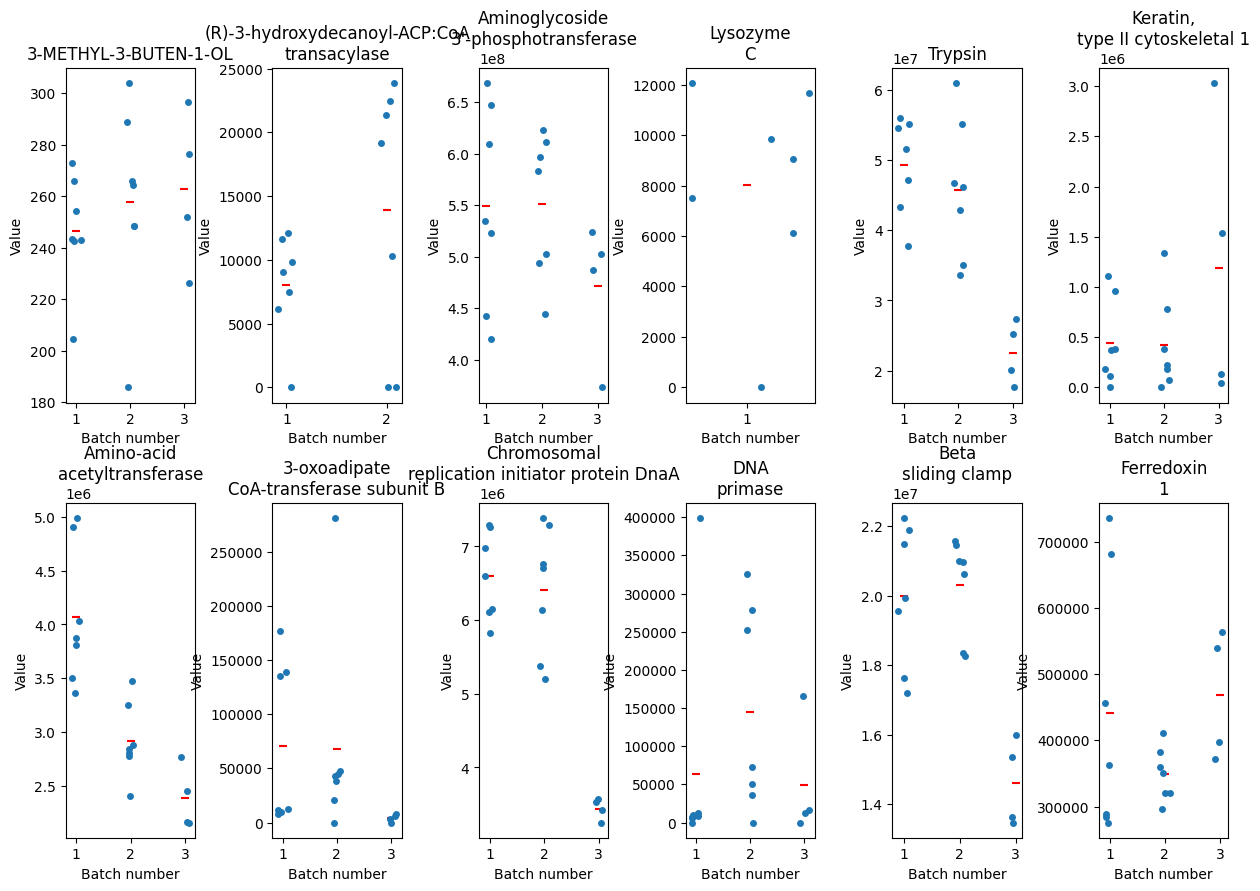

In [35]:
def compare_swarm(df, measurement_type, batches, ax = None, to_plot = 'Value'):
    if ax is None:
        fig, ax = plt.subplots(figsize = (len(batches), 5))
    df = df[df['Batch number'].isin(batches)]
    sns.stripplot(df[df['Measurement Type'] == measurement_type], x = 'Batch number', y = to_plot)
    
    #Add mean as red dot
    mean_vals = [np.mean(df[(df['Measurement Type'] == measurement_type) & (df['Batch number'] == batch_num)][to_plot]) for batch_num in batches]
                         
    _ = [ax.scatter(i, mean_vals[i], color = 'red', marker = '_') for i in range(len(batches))]
    plt.title(measurement_type)

def compare_swarm_multi(df, measurement_type, batches, to_plot = 'Value'):
    n_measures = len(measurement_type)
    fig = plt.figure(figsize=(15, 5*np.ceil(len(measurement_type)/6)))
    fig.subplots_adjust(hspace=0.3, wspace=0.6)
    #fig.suptitle('Comparing batches')
    
    for ii, m in enumerate(measurement_type):
        ax = fig.add_subplot(int(np.ceil(len(measurement_type)/6)), 6, (ii+1))
        compare_swarm(df, m, batches, ax, to_plot = to_plot)
        ax.set_title(m.replace(' ', '\n', 1))

target_list_all = df_control['Measurement Type'].unique().tolist()
compare_swarm_multi(df_control, target_list_all[:12], [1,2,3])

#### Plot differences b/w measurements on each day
Calculating $\Delta$(counts) for (day 3) - (day 1) should skew negative for unnormalized data, but should go away with normalization.

Create function to plot the distribution of differences between days. 

In [36]:
def plot_distribution_of_differences(meas_pivot, comparisons, labels):
    """
    Take a pivot table of measurements in and plot distributions of comparisons between days.
    """
    n_comparisons = len(comparisons)
    fig, ax = plt.subplots(nrows = 1, ncols = n_comparisons)
    for ii in range(n_comparisons):
        dif_current = meas_pivot[comparisons[ii][0]] - meas_pivot[comparisons[ii][1]]
        sns.histplot(dif_current, ax = ax[ii])
        ax[ii].set_xlabel(labels[ii])
    return fig, ax       

Make pivot tables for normalized an unnormalized data and set up labels. 

In [37]:
cntrl_pivot_by_measurement_nonnorm = pd.pivot_table(df_norm, values = 'Value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
cntrl_pivot_by_measurement_norm = pd.pivot_table(df_norm, values = 'norm_value', columns = 'Batch number', index = 'Measurement Type', aggfunc = np.mean)
dif_to_plot = [[3, 1],
               [2, 1]]
dif_labels = ['day 3 - day 1',
              'day 2 - day 1']

Make plots to show the distribution of differences. 

[(-10000000.0, 10000000.0), (-10000000.0, 10000000.0)]

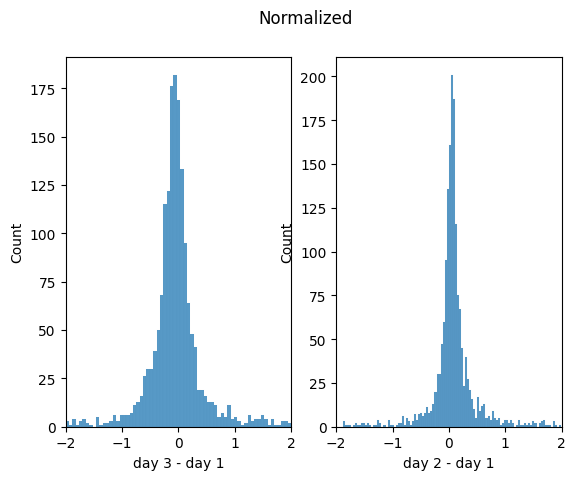

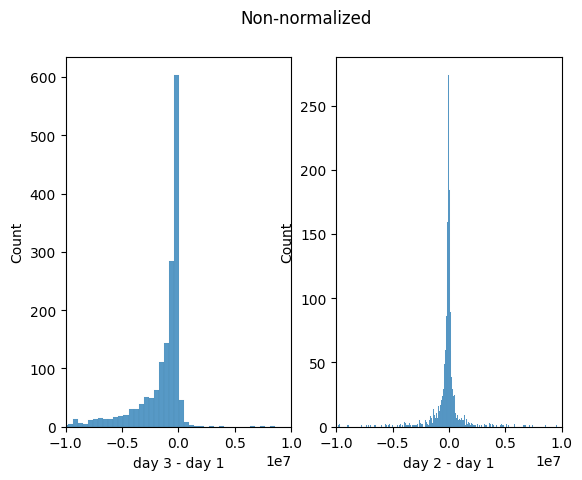

In [38]:
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_norm, dif_to_plot, dif_labels)
ax_lim = 2
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]
fig.suptitle('Normalized')

ax_lim = 1e7
fig, ax = plot_distribution_of_differences(cntrl_pivot_by_measurement_nonnorm, dif_to_plot, dif_labels)
fig.suptitle('Non-normalized')
[ax[ii].set_xlim([-ax_lim, ax_lim]) for ii in range(len(ax))]

#### Swarmplots for normalized values
These swarmplots compare the distribution of all proteins on each day before and after normalization. We can see that the normalization makes the difference in distributions much less. 



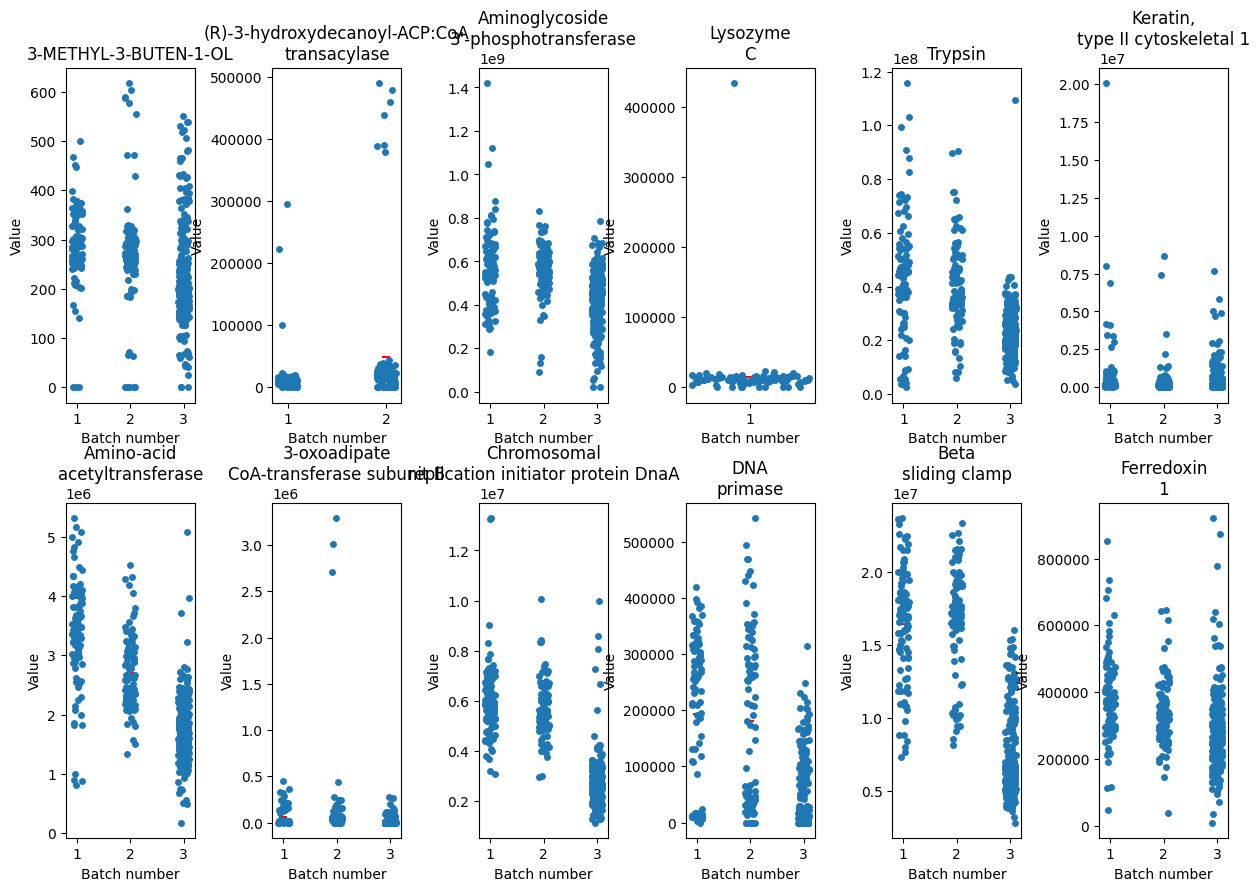

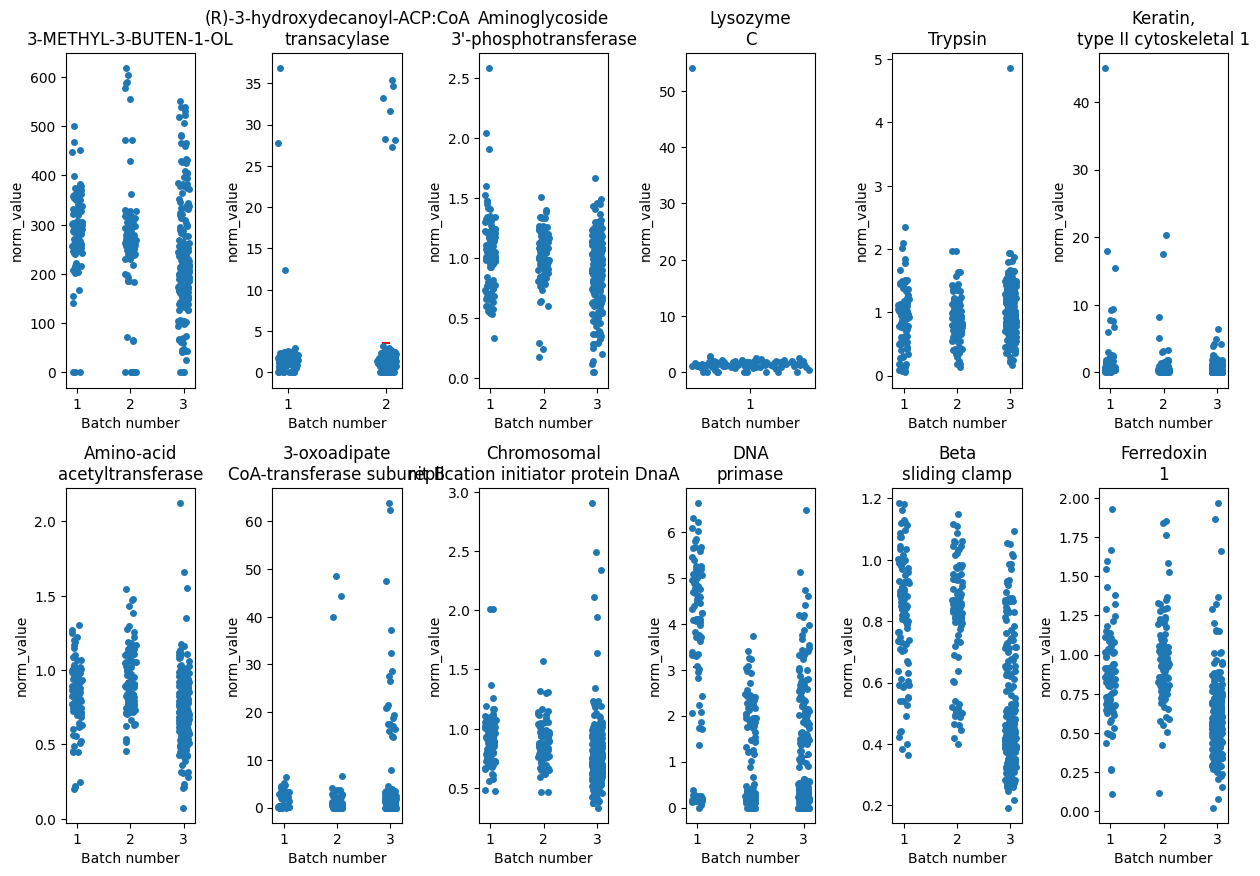

In [39]:
target_list_filter = df_norm['Measurement Type'].unique().tolist()

compare_swarm_multi(df_norm, target_list_filter[:12], [1,2,3], to_plot='Value')

compare_swarm_multi(df_norm, target_list_filter[:12], [1, 2, 3], to_plot='norm_value')


## Check the efficacy of CRISPRi - preprocessing
Now that we have normalized the data, we can proceed with Hector's filtering of the proteomics data in order to check how CRISPi performed. To do so, we will:
1. Get Strain Names
2. Get uniprot names for proteins ('Formal Type') column in dataframe
3. Map uniprot IDs to protein names using provided spreadsheet
4. Drop the rows that are not in targets from the proteomics protocol:
5. Change names from Uniprot to PP_ name
6. Add target gene

Define some useful functions.

Print some information from dataframes - unique line descriptors, names, formal types, and Protocols. Also, check negative values - there shouldn't be any in proteomics data.

In [40]:
unique_line_desc = df_norm['Line Description'].unique()
print('Line descriptions length and unique entries')
print(len(unique_line_desc))
print(unique_line_desc[:20])

print('Line names length and unique entries')
unique_line_name = df_norm['Line Name'].unique()
print(len(unique_line_name))
print(unique_line_name[:20])

print('Formal Types length and unique entries')
unique_formal_types = df_norm['Formal Type'].unique()
print(len(unique_formal_types))
print(unique_formal_types[:20])

print('Unique protocols')
print(df_norm['Protocol'].unique())

print(f'There are {len(df_norm[df_norm["Value"]<0])} negative values in df_norm')

Line descriptions length and unique entries
420
['BL1A2_IY1586' 'BL1A3_IY1587' 'BL1A4_IY1588' 'BL1A5_IY1589'
 'BL1A6_IY1590' 'BL1A7_IY1591' 'BL1A8_IY1592' 'BL1B2_IY1586'
 'BL1B3_IY1587' 'BL1B4_IY1588' 'BL1B5_IY1589' 'BL1B6_IY1590'
 'BL1B7_IY1591' 'BL1B8_IY1592' 'BL1C2_IY1586' 'BL1C3_IY1587'
 'BL1C4_IY1588' 'BL1C5_IY1589' 'BL1C6_IY1590' 'BL1C7_IY1591']
Line names length and unique entries
420
['PP_4549-R1' 'PP_4550-R1' 'PP_0368-R1' 'PP_2136-R1' 'PP_0774-R1'
 'PP_0362-R1' 'PP_0437-R1' 'PP_4549-R2' 'PP_4550-R2' 'PP_0368-R2'
 'PP_2136-R2' 'PP_0774-R2' 'PP_0362-R2' 'PP_0437-R2' 'PP_4549-R3'
 'PP_4550-R3' 'PP_0368-R3' 'PP_2136-R3' 'PP_0774-R3' 'PP_0362-R3']
Formal Types length and unique entries
2694
['cid:12988' 'sp|O85207|PHAG_PSEPK Phag' 'sp|P00552|KKA2_KLEPN Neo'
 'sp|P00698|LYSC_CHICK Lysozyme C' 'sp|P00761|TRYP_PIG Trypsin'
 'sp|P04264' 'sp|P0A0Z9|ARGA_PSEPK Arga' 'sp|P0A101|PCAJ_PSEPK Pcaj'
 'sp|P0A116|DNAA_PSEPK Dnaa' 'sp|P0A118|DNAG_PSEPK Dnag'
 'sp|P0A120|DPO3B_PSEPK Dnan' 'sp|P0A1

### 1. Add strain name to dataframe using prebuilt function.


In [41]:
df_norm["Strain"] = create_strain_names(df_norm)
print(df_norm.shape)

(1032300, 12)


### 2. Bring out Uniprot names

In [42]:
get_Uniprot = lambda x: re.sub('.*\|(.*)\|.*', r'\1', x)

get_uniprot_teststring = 'sp|Q9Z408|CSD_PSEPK Csda'

print(f'test string to extract uniprot: {get_uniprot_teststring} \nfunction output: {get_Uniprot(get_uniprot_teststring)}')

test string to extract uniprot: sp|Q9Z408|CSD_PSEPK Csda 
function output: Q9Z408


In [43]:
df_norm['Formal Type'] = df_norm['Formal Type'].apply(get_Uniprot)
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604,IY1586
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975,IY1587
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714,IY1588
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097,IY1589
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588,IY1590


In [44]:
print(df_norm.shape)

(1032300, 12)


### 3. Limit protein data to target genes. 
Since we only need the proteomics data for the target genes, we will only keep that. To figure out the target genes, we need to get the file mapping Uniprot IDs to PPxx names for the target genes:

In [45]:
ProtMapping_df = pd.read_excel(user_params['protein_map'])
ProtMapping_df.head()


,Sample name,CRISPRi target gene,UNIPROT ID
0,IY1452_pIY1079,PP_1607_NT2,Q88MG4
1,IY1452_pIY1080,PP_1607_NT3,Q88MG4
2,IY1452_pIY1081,PP_1607_NT4_R1,Q88MG4
3,IY1452b_pIY1081,PP_1607_NT4_R2,Q88MG4
4,IY1452c_pIY1081,PP_1607_NT4_R3,Q88MG4


We will limit CRISPRi target gene name to standard names (e.g. we will convert 'PP_1607_NT2' to 'PP_1607')

In [46]:
ProtMapping_df["CRISPRi target gene"] = ProtMapping_df["CRISPRi target gene"].apply(lambda x: x[0:7])


#### Protein-gene mapping sanity checks.
Need to check two things about protein-gene mapping:

- Are all of the target proteins still in the dataframe? Some could have been dropped if they could not be normalized.
- Is there a 1 to 1 correspondence between target genes and uniprot IDs?

First check if we dropped any target proteins.

In [47]:
#Create dataframe from full data and transform 'Formal Type' to get targets from full dataset
df2['Formal Type'] = df2['Formal Type'].apply(get_Uniprot)

targets_in_mapping = ProtMapping_df['UNIPROT ID'].unique().tolist()
targets_in_df_norm = df_norm['Formal Type'].unique().tolist()
targets_in_df_full = df2['Formal Type'].unique().tolist()
print(f'There are {len(targets_in_mapping)} unique targets in xlsx file\n' 
        f'{len(targets_in_df_norm)} unique targets in norm dataframe\n'
        f'{len(targets_in_df_full)} unique targets in full dataframe')

targets_not_in_df_norm = [ii for ii in targets_in_mapping if ii not in targets_in_df_norm]
print(f'Targets in mapping that have been dropped from df_norm: \n {targets_not_in_df_norm}')

targets_not_in_df_full = [ii for ii in targets_in_mapping if ii not in targets_in_mapping in targets_in_df_full]
print(f'There are {len(targets_not_in_df_full)} targets in map that are not in full dataframe')

There are 122 unique targets in xlsx file
2694 unique targets in norm dataframe
2696 unique targets in full dataframe
Targets in mapping that have been dropped from df_norm: 
 ['Q88QX2', 'Q88JR0', 'Q88GH9', 'Q88HG4', 'Q88HK1', 'Q88HS1', 'Q88N22', 'Q88HS3', 'Q88DT2', 'P0A103', 'Q88PP2', 'Q88FG8', 'Q88FP6', 'Q88RM5', 'Q88RM4', 'Q88RM3', 'Q88PN5', 'Q88PN4', 'Q88FD7', 'A0A140FWL1', 'Q88FD8', 'Q88R57']
There are 0 targets in map that are not in full dataframe


Next check if there's a 1 to 1 correspondence in mapping. There should be several targets and genes that have multiple entries due to trying multiple guide RNAs/constructs, but the number of duplicate target genes and duplicate UNIPROT IDs should match and have the same number of duplicates. Note also that according to uniprot, UPID Q877U6 is associated with genes PP1157 and PP3365. https://www.uniprot.org/uniprotkb/Q877U6/entry

In [48]:
number_crispr_target_genes = len(ProtMapping_df["CRISPRi target gene"].unique())
number_uniprot_id = len(ProtMapping_df["UNIPROT ID"].unique())
target_value_counts = ProtMapping_df["CRISPRi target gene"].value_counts()
upid_value_counts = ProtMapping_df['UNIPROT ID'].value_counts()

print(f'In the Protein Mapping spreadsheet, there are {number_crispr_target_genes} unique target genes and {number_uniprot_id} unique uniprot IDs')
print('These targets have show up multiple times in the list:')
print(target_value_counts[target_value_counts>1])
print('These Uniprot IDs show up multiple times')
print(upid_value_counts[upid_value_counts>1])


In the Protein Mapping spreadsheet, there are 123 unique target genes and 122 unique uniprot IDs
These targets have show up multiple times in the list:
PP_1607    10
PP_0528     3
PP_0548     3
PP_4679     3
PP_4194     2
Name: CRISPRi target gene, dtype: int64
These Uniprot IDs show up multiple times
Q88MG4    10
Q88DY9     3
Q88QG6     3
Q88QE6     3
Q88FA4     2
Q877U6     2
Name: UNIPROT ID, dtype: int64


### 4. Drop the rows that are not in targets from Proteomics protocol:

In [49]:
df_norm = df_norm.drop(
                    index=df_norm[(~df_norm['Formal Type'].isin(targets_in_mapping)) &
                                  (df_norm['Protocol']=='Global Proteomics')].index)
print(df_norm.shape)


(41712, 12)


### 5. Change names from Uniprot to PP_ names
Create a protein mapping dictionary that translates from Uniprot to PP names:

In [50]:
protein_map = {}
for index in ProtMapping_df.index:
    protein_map[ProtMapping_df.loc[index,"UNIPROT ID"]] = ProtMapping_df.loc[index,"CRISPRi target gene"]

Do the translation:

In [51]:
proteomics_ind = df_norm['Protocol']=='Global Proteomics'
df_norm.loc[proteomics_ind,'Formal Type'] = df_norm.loc[proteomics_ind,'Formal Type'].apply(lambda x: protein_map[x])

### 6. Add Target Gene
Add column with a target gene for each strain.

In [52]:
get_target_gene = lambda x: re.split('-', x)[0][0:7] # last part eliminates non standard names from PP name (e.g. PP_1607_NT3)
get_target_gene_teststring = 'PP_4549-R1'
print(f'To get target gene:\n Input string: {get_target_gene_teststring}, output: {get_target_gene(get_target_gene_teststring)}')

To get target gene:
 Input string: PP_4549-R1, output: PP_4549


In [53]:
df_norm['Target'] = df_norm['Line Name'].apply(get_target_gene)
df_norm.head()

,Line Name,Line Description,Protocol,Formal Type,Measurement Type,Value,Control,Batch number,can_normalize,control_val,norm_value,Strain,Target
149130,PP_4549-R1,BL1A2_IY1586,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,298.9604,False,1,1,246.680643,298.9604,IY1586,PP_4549
149131,PP_4550-R1,BL1A3_IY1587,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,167.3975,False,1,1,246.680643,167.3975,IY1587,PP_4550
149132,PP_0368-R1,BL1A4_IY1588,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,340.5714,False,1,1,246.680643,340.5714,IY1588,PP_0368
149133,PP_2136-R1,BL1A5_IY1589,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,348.5097,False,1,1,246.680643,348.5097,IY1589,PP_2136
149134,PP_0774-R1,BL1A6_IY1590,GC-FID,cid:12988,3-METHYL-3-BUTEN-1-OL,215.1588,False,1,1,246.680643,215.1588,IY1590,PP_0774


## Statistical Analysis
### Pivot dataframe to table:

Pivot dataframe to table with strain as the row name, columns as the gene, and proteomics values as the value. Create one for normalized values and one for non-normalized values.

In [54]:
df_targets_norm = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "norm_value", aggfunc = np.mean)

df_targets = df_norm.pivot_table(
    index = "Strain", columns = ["Formal Type"], values = "Value", aggfunc = np.mean)

In [55]:
df_targets.head()

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,3.586415e+06,NaN,9.210642e+06,NaN,142166.586667,6.109116e+07,8.039113e+06,298727.406667,9.636014e+05,NaN,...,6.638675e+06,3.309500e+07,714464.702222,264223.151111,2.445540e+06,5.063224e+06,7.287413e+06,2.881347e+07,8.183859e+05,289.814111
IY1586,4.941056e+06,NaN,1.236235e+07,NaN,308027.333333,6.355352e+07,7.188374e+06,554030.300000,1.033685e+06,NaN,...,3.389466e+06,3.538221e+07,802231.100000,161008.533333,3.504255e+06,6.403841e+06,7.892991e+06,3.218307e+07,4.716865e+05,302.681833
IY1587,3.383160e+06,NaN,6.041816e+06,NaN,149748.286667,5.562492e+07,6.100304e+06,404533.066667,8.223293e+05,NaN,...,2.688070e+06,4.170485e+07,337268.900000,42837.280000,7.075045e+06,5.252234e+06,7.197036e+06,3.061075e+07,2.213753e+05,154.452567
IY1588,3.782190e+06,NaN,1.541983e+07,NaN,532825.913333,8.523304e+07,2.806301e+05,478575.080000,9.449282e+05,NaN,...,3.791270e+06,4.037166e+07,768653.320000,170738.773333,4.443869e+06,5.520132e+06,7.560586e+06,3.083117e+07,1.164940e+06,355.020800
IY1589,5.161205e+06,NaN,6.916297e+06,NaN,175308.100000,5.926596e+07,3.409878e+07,442735.666667,1.115515e+06,NaN,...,2.764658e+06,3.808640e+07,641292.433333,275513.400000,2.478471e+06,4.940154e+06,7.361192e+06,3.034837e+07,9.698603e+05,351.199900


In [56]:
df_targets_norm.head()

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,cid:12988
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,2.075548,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,1.059699,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,0.840411,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,1.185321,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.864356,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900


Change compound ID to Isoprenol

In [57]:
df_targets_norm.rename(columns = {'cid:12988': 'Isoprenol mean'}, inplace = True)
df_targets_norm.head()

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5064,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,2.075548,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,1.059699,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,0.840411,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,1.185321,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.864356,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900


Add the target genes to this table - create a map from the strains and targets in df_norm.

In [58]:
target_map = df_norm[['Strain', 'Target']].drop_duplicates().set_index("Strain")
target_map


,Target
Strain,
IY1586,PP_4549
IY1587,PP_4550
IY1588,PP_0368
IY1589,PP_2136
IY1590,PP_0774
...,...
IY2029,PP_4123
IY2032,PP_4128
IY2019,PP_5420


In [59]:
df_targets_norm.loc[target_map.index, 'Target'] = target_map['Target']
df_targets_norm.head()

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


Some target genes are not present in the proteomics data:

In [60]:
for gene in df_targets_norm["Target"]:
    if gene not in df_targets.columns:
        print(gene)

PP_0362
PP_2589
PP_3744
PP_3394
PP_3355
PP_3282
PP_1157
PP_1394
PP_3280
PP_4737
PP_5420
PP_0806
PP_4128
PP_4043
PP_0104
PP_0105
PP_0106
PP_0814
PP_0815
PP_4161
PP_4160
PP_4159
PP_0277
Control


### Proteomics data

Now we can add the statistical data from the proteomics data (mean, std, first and third quantile):

In [61]:
df_targets_norm = find_library_stats(df_targets_norm)
df_targets_norm.head()

/tmp/ipykernel_1052555/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1052555/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1052555/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None
/tmp/ipykernel_1052555/3550479664.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df.loc[n] = None


Data for these 24 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'Control']


Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,0.844318,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,0.902669,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,1.063972,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,1.029959,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.971658,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136


### Isoprenol production data

Find CV for isoprenol production.

In [62]:
df_isoprenol             = df_norm[df_norm['Measurement Type']=='3-METHYL-3-BUTEN-1-OL']
df_isoprenol             = df_isoprenol.drop(columns=['Line Name', 'Line Description', 'Measurement Type', 'Protocol','Control', 'Batch number', 'can_normalize'])
stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
stats_isoprenol.rename(columns={'Value': 'mean'}, inplace=True)
stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']
stats_isoprenol['CV[%]'] = 100* stats_isoprenol['std'] / stats_isoprenol['mean']
stats_isoprenol = stats_isoprenol.sort_values('CV[%]', ascending=False)
stats_isoprenol.head()

/tmp/ipykernel_1052555/1808311546.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol          = df_isoprenol.groupby(['Strain']).mean()
/tmp/ipykernel_1052555/1808311546.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  stats_isoprenol['std']   = df_isoprenol.groupby(['Strain']).std()['Value']


,mean,control_val,norm_value,std,CV[%]
Strain,,,,,
IY2192,15.849800,262.882475,15.849800,27.452659,173.205081
IY1671,100.588117,260.397102,100.588117,110.470009,109.824115
IY2025,27.581113,262.882475,27.581113,23.906693,86.677767
IY2195,63.463733,262.882475,63.463733,39.644337,62.467704
IY1597,275.054650,254.781559,275.054650,93.993453,34.172646


Add these stats to the dataframe:

In [63]:
product = 'Isoprenol'
df_isoprenol.rename(columns={'Value': product}, inplace=True)
df_isoprenol = df_isoprenol.sort_values(product, ascending=False)
df_isoprenol['CV[%]'] = None

strains = [strain for strain in stats_isoprenol.index.unique()]
for strain in strains:
    index = df_isoprenol[df_isoprenol['Strain']==strain].index
    cv_value = stats_isoprenol[stats_isoprenol.index==strain]['CV[%]'].values
    df_isoprenol.loc[index, 'CV[%]'] = np.ones(len(index))*cv_value

df_isoprenol.drop(columns='Formal Type', inplace=True)
df_isoprenol.set_index("Strain", inplace=True)
df_targets_norm.loc[df_isoprenol.index,["CV[%]","Target"]] = df_isoprenol.loc[:,["CV[%]","Target"]]


In [64]:
df_targets_norm.head()

Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,Isoprenol mean,Target,CV[%]
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,0.774208,0.937731,0.708980,0.947156,0.915955,0.937266,0.600624,289.814111,PP_1607,20.218016
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,0.869313,0.571421,1.015910,1.197940,0.992070,1.046875,0.346177,302.681833,PP_4549,1.258797
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,0.365471,0.152030,2.051109,0.982514,0.904596,0.995729,0.162470,154.452567,PP_4550,8.410108
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,0.832928,0.605954,1.288311,1.032628,0.950290,1.002899,0.854964,355.020800,PP_0368,4.072284
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.694917,0.977801,0.718528,0.924134,0.925228,0.987194,0.711793,351.199900,PP_2136,0.74632


## Data Visualization
Visualize isoprenol production and CV. First, some useful functions.

In [65]:
def plot_filter_results(df_all, df_filter, horiz_thresh, vert_thresh, x_fields):
    n_plots = len(x_fields)
    fig,ax = plt.subplots(1,n_plots)
    
    for ii in range(n_plots):
        ax[ii].scatter(df_all[x_fields[ii]], df_all['Isoprenol mean'], color = 'blue', alpha = 0.5, label = 'all targets')
        ax[ii].scatter(df_filter[x_fields[ii]], df_filter['Isoprenol mean'], color = 'red', label = 'targets after filtering')
        ax[ii].set_xlim([0, 2])
        ax[ii].axvline(vert_thresh[ii], color = 'k')
        ax[ii].axhline(horiz_thresh[ii], color = 'k')
        ax[ii].set_xlabel(x_fields[ii])
        if ii == 0:
            ax[ii].set_ylabel('Isoprenol Mean')
            ax[ii].legend()
    return fig

In [66]:
def plot_titers(df_prod, df_control_stat, product='Isoprenol'):
    "Plots isprenols titers as well as CV"
        
    ## create figure
    fig, ax = plt.subplots(figsize=(20,5))
    sns.set_style('white')

    ## Plot production in salmon color
    g = sns.scatterplot(data=df_prod,
                        x = 'Strain',
                        y = product,
                        color = 'salmon',
                        )
    ## Format isoprenol axis
    g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
    control_xval = np.where(df_prod.index.unique() == 'NT')
    plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
                df_control_stat[product], 
                marker = 'o', 
                color = 'none', 
                edgecolor = 'k', 
                label = 'control')
    
    ax.set_ylabel(product + " [uM]", fontsize=10, color='salmon')
    ax.set_xlabel("Strains", fontsize=10)
    
    ## Create %CV axis
    ax2 = plt.twinx()
    g2 = sns.scatterplot(data=df_prod,
                        x='Strain',
                        y='CV[%]', 
                        color='gray',
                        marker='o',
                        ax=ax2)
    plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],
                    marker='o', color="None",  edgecolor='k', label='Control'
                    )
    ax2.set_ylabel("CV[%]", fontsize=10, color='gray')
    sns.despine(left=True, bottom=True)
    ax.legend()
    ## Save figure
    fig.savefig(
        f"{user_params['output_dir']}/titer_cv.png",
        transparent=True,
        bbox_inches="tight",
        dpi=300,
    )

In [95]:
def plot_crispr_library(df_long, df_targets,targetsP, save = True, save_name = None, violin_field = 'Value'):
    
    # Figure dimensions, color and label
    fig_height = 15
    color = 'tomato'
    ylabel = 'Proteomics'
    
    # Keep only strains in index (assumed to have a non NaN value for production)    
    df_crispr = df_targets.loc[df_targets['Isoprenol mean'].dropna().index,:]
    df_crispr.sort_values('Isoprenol mean', ascending=False, inplace=True)
    
    # Create figure
    fig = plt.figure(figsize=(15, fig_height))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    fig.suptitle(f'CRISPRi')

    for target in targetsP:
        i = targetsP.index(target)
        # Creating axes of the right size
        ax = fig.add_subplot(int(np.ceil(len(targetsP)/5)), 5, (i+1))
        if i==0:
            ax.set_ylabel(ylabel, fontsize=10)
        else:
            ax.set_ylabel(None)
        ax.set_xlabel(None)
            
        
        if target in df_crispr.columns.tolist():
            # Add violinplot
            data = df_long[df_long['Formal Type']==target]
            if len(data)>0:
                sns.violinplot(
                    data=data, 
                    x='Formal Type',
                    y=violin_field,
                    orient='v',
                    width=0.05,
                    linewidth=1, color='lightgray', alpha=0.3
                )

            # Add control
            plt.plot(df_targets.loc[control_strain, target], '.', color='k', markersize=10)

            # Add target
            data = df_targets[df_targets['Target']==target][target]
            if len(data)==1:
                plt.plot(data, marker='_', color=color, markersize=50, markeredgewidth=3)

            # Set y limits
            #ylim = np.max(df_targets[target]) + 50
            #ax.set_ylim([0, ylim])

        sns.despine(left=False, bottom=True)
        if save_name is None:
            save_name = f"{user_params['output_dir']}/crispri_{ylabel}.png"
        if save:
            fig.savefig(
                save_name,
                transparent=True,
                bbox_inches="tight",
                dpi=300,
                )
    return fig, df_crispr

In [68]:
df_isoprenol.head()

,Isoprenol,control_val,norm_value,Target,CV[%]
Strain,,,,,
IY2020,618.3056,257.911729,618.3056,PP_5419,5.359461
IY1688,603.9709,257.911729,603.9709,PP_0528,2.279287
IY1688,590.6272,257.911729,590.6272,PP_0528,2.279287
IY2020,587.8620,257.911729,587.8620,PP_5419,5.359461
IY1688,577.0506,257.911729,577.0506,PP_0528,2.279287


In [69]:
control_strain = df_norm.loc[df_norm['Control']==True,:]['Strain'].unique()[0]
df_control_stat = df_isoprenol.loc[control_strain]

/tmp/ipykernel_1052555/513522599.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(df_prod.index.unique(), fontsize=10, rotation = 90)
/tmp/ipykernel_1052555/513522599.py:17: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval*np.ones(df_control_stat[product].shape),
/tmp/ipykernel_1052555/513522599.py:35: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.scatter(control_xval, df_control_stat['CV[%]'].iloc[0],


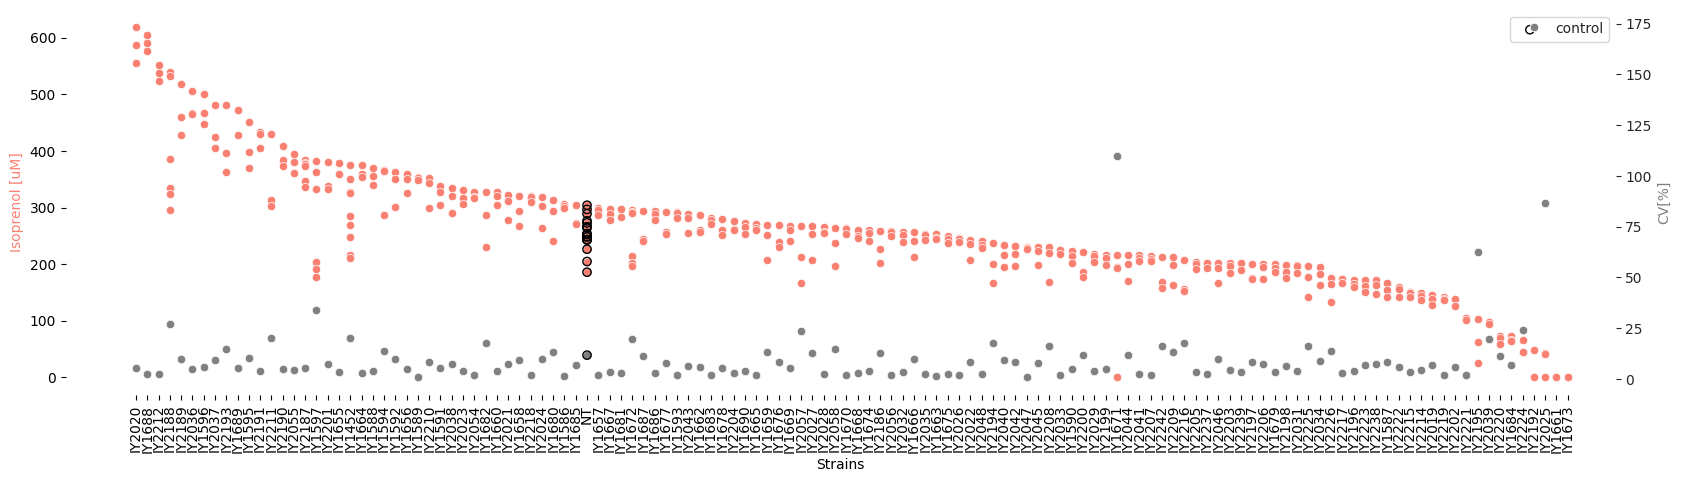

In [70]:
plot_titers(df_isoprenol, df_control_stat, 'Isoprenol')

Visualize distribution of proteomics levels in each strain (distributions) compared to the strain where that protein was targeted. 

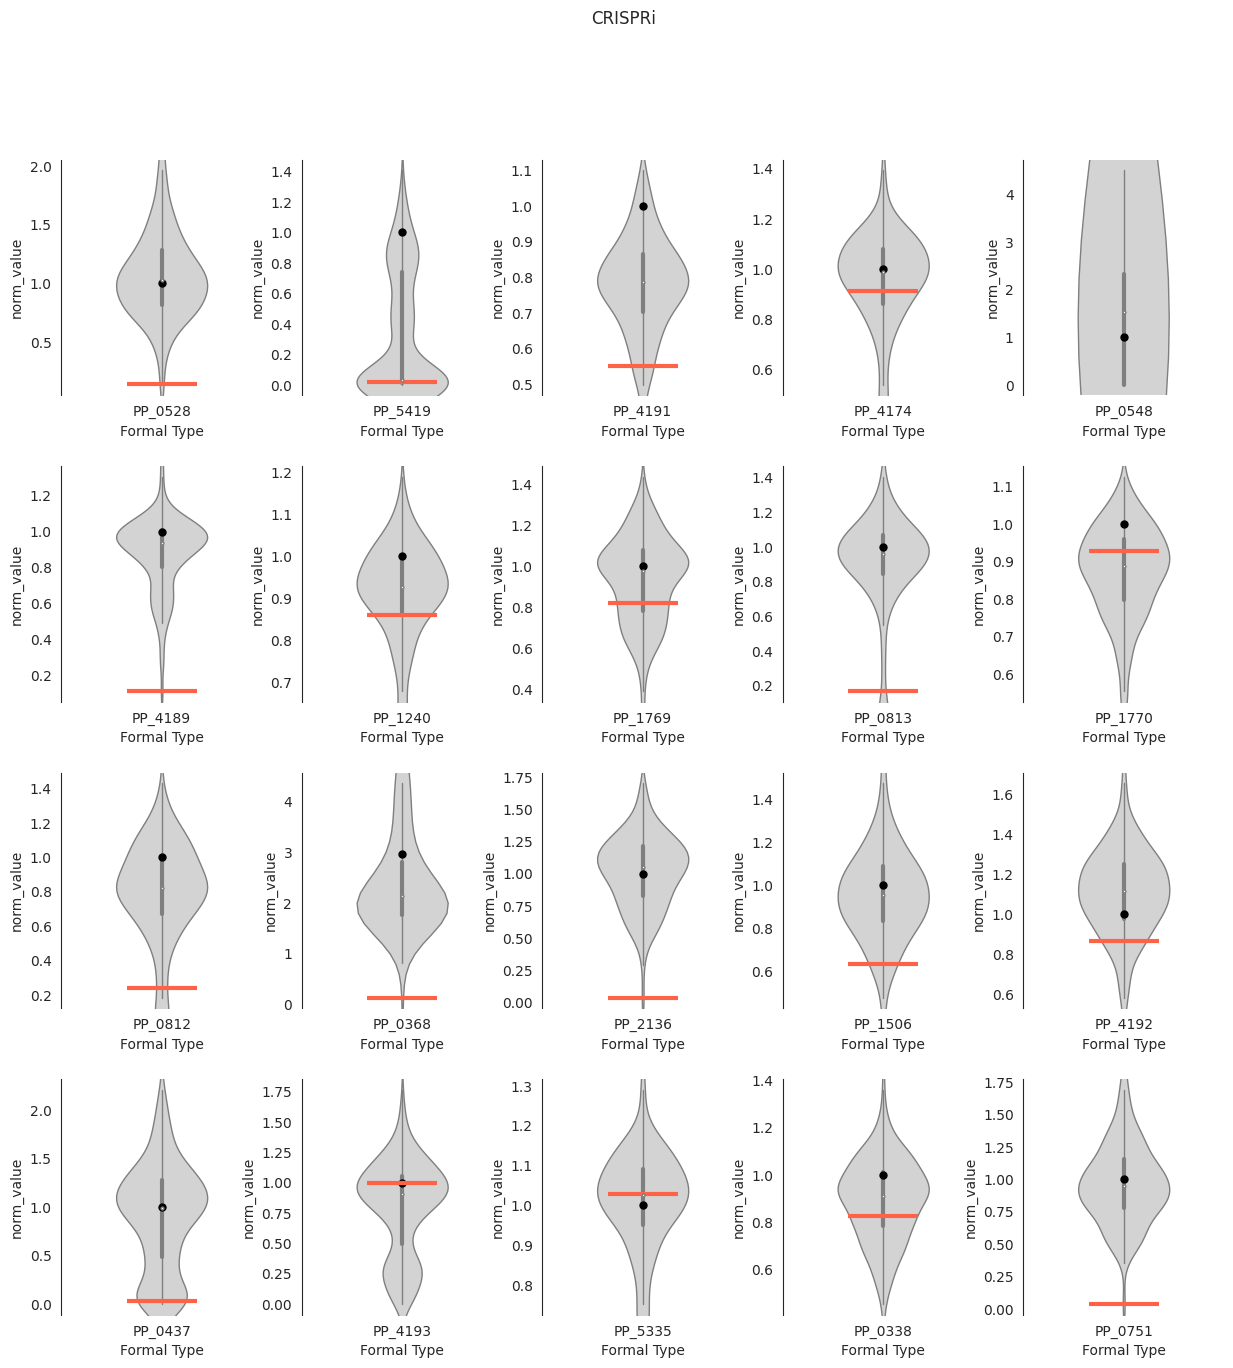

In [71]:
df_crispr = df_targets_norm.loc[df_targets_norm['Isoprenol mean'].dropna().index,:]
df_crispr.sort_values("Isoprenol mean", ascending = False, inplace = True)  

targets_all = list(df_crispr['Target'].values)
targets_filter = []
for tt in targets_all:
    if (sum(df_targets_norm['Target'] == tt) == 1) and (tt in df_norm['Formal Type'].unique()):
        targets_filter.append(tt)
targetsP = targets_filter[:20]

fig = plot_crispr_library(df_norm, df_targets_norm, targetsP, save=False, violin_field='norm_value')


## Make Recommendations - Selecting Target Genes
Criteria for downselection:

Transcription value for the CRISPRi targeted gene:
Within the bottom 25th percentile of the library
More than 25% lower than the mean of the library

Define functions:

In [72]:
def choose_targets(df_targets, size, n_instances, weighting=True, verbose=0):
    "Choose recommended double and triple targets for CRISPRi knockdown"

    targets_list = list(df_targets['Target'])
    targets = set()
    tries = 0
    if weighting:
        weights = df_targets['Weight']
    else:
        weights = None
    
    while len(targets) < n_instances:
        new_target = tuple(sorted(random.sample(
            targets_list, counts=weights, k=size
        ))) # random sampling without replacement
        # new_target = sorted(random.choices(targets_list, weights=weights, k=size))
        # Check that the targets are not the same (sample function could provide repeated targets)
        # and if the combination was already chosen
        if len(set(new_target)) == size and new_target not in targets:
            targets.add(new_target)
        tries += 1
        
    if verbose:
        print(tries)
        
    return list(targets)

In [73]:
 def plot_double_targets(targets_double, df_targets):
    "Plot double targets chosen with the function above"    
        
    fig, ax = plt.subplots(figsize=(7, 11), nrows=2)
    fig.patch.set_facecolor("white")

    n_targets = len(df_targets)
    
    target1 = [target[0] for target in targets_double]
    target2 = [target[1] for target in targets_double]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]

    ax[0].plot(x, y, 'o')
    ax[0].set_xlabel('Target 1')
    ax[0].set_ylabel('Target 2')
    ax[0].set_yticks(range(n_targets), df_targets['Target'].values)
    ax[0].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    ax[0].set_title("Double targets")

    x.extend(y)
    ax[1].hist(x, bins=range(n_targets+1), rwidth=0.9, align='left')
    ax[1].set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    t = ax[1].set_ylabel("Frequency of targets")

In [74]:
 def plot_triple_targets(targets_triple, df_targets):
    "Plot triple targets chosen with the function above"    
   
    fig, ax = plt.subplots(figsize=(7, 5))
    fig.patch.set_facecolor("white")
    
    n_targets = len(df_targets)

    target1 = [target[0] for target in targets_triple]
    target2 = [target[1] for target in targets_triple]
    target3 = [target[2] for target in targets_triple]

    x = [df_targets[df_targets['Target']==target].index[0] for target in target1]
    y = [df_targets[df_targets['Target']==target].index[0] for target in target2]
    z = [df_targets[df_targets['Target']==target].index[0] for target in target3]

    x.extend(y)
    x.extend(z)
    ax.hist(x, bins=range(n_targets+1), rwidth=0.8, align='left')
    ax.set_xticks(range(n_targets), df_targets['Target'].values, rotation='vertical')
    # ax.set_xticks(range(n_targets), range(n_targets), rotation='vertical')
    t = ax.set_ylabel("Frequency of targets")
    

### Calculate ratios

We calculate the ratios of the target protein concentration to the control, library mean, Q1 and Q3 (eliminating the strain with the target gene):

In [75]:
df_targets_norm = find_fold_changes(df_targets_norm)
df_targets_norm.head()

Data for these 24 proteins was not present:
['PP_0362', 'PP_2589', 'PP_3744', 'PP_3394', 'PP_3355', 'PP_3282', 'PP_1157', 'PP_1394', 'PP_3280', 'PP_4737', 'PP_5420', 'PP_0806', 'PP_4128', 'PP_4043', 'PP_0104', 'PP_0105', 'PP_0106', 'PP_0814', 'PP_0815', 'PP_4161', 'PP_4160', 'PP_4159', 'PP_0277', 'Control']


Formal Type,PP_0001,PP_0103,PP_0168,PP_0225,PP_0226,PP_0338,PP_0368,PP_0437,PP_0528,PP_0548,...,PP_5417,PP_5419,Isoprenol mean,Target,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3,Z-score
Strain,,,,,,,,,,,,,,,,,,,,,
IY1452,0.666356,NaN,0.972544,NaN,0.598629,0.842324,3.671102,0.620934,1.081068,NaN,...,0.937266,0.600624,289.814111,PP_1607,20.218016,0.835546,0.895268,0.950706,0.837033,-0.859869
IY1586,0.918049,NaN,1.305330,NaN,1.297028,0.876275,3.282608,1.151605,1.159695,NaN,...,1.046875,0.346177,302.681833,PP_4549,1.258797,0.051181,0.073447,0.088091,0.062293,-3.672694
IY1587,0.628591,NaN,0.637950,NaN,0.630554,0.766956,2.785735,0.840861,0.922574,NaN,...,0.995729,0.162470,154.452567,PP_4550,8.410108,0.806427,0.271305,1.172693,0.283344,-0.325976
IY1588,0.702731,NaN,1.628167,NaN,2.243601,1.175192,0.128151,0.994764,1.060118,NaN,...,1.002899,0.854964,355.020800,PP_0368,4.072284,0.043326,0.050764,0.071139,0.04522,-1.643198
IY1589,0.958952,NaN,0.730286,NaN,0.738180,0.817158,15.571383,0.920269,1.251501,NaN,...,0.987194,0.711793,351.199900,PP_2136,0.74632,0.036127,0.03451,0.040185,0.031508,-3.533457


In [76]:
cols = [
    'Target',
    'Isoprenol mean','CV[%]',
    'Target:Control','Target:Library_mean',
    'Target:Library_Q1','Target:Library_Q3'
]
df_filtering = df_targets_norm.loc[strains][cols]
df_filtering

Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY2192,PP_5064,15.849800,173.205081,0.979425,0.831695,1.174694,0.750364
IY1671,PP_4679,100.588117,109.824115,0.442137,0.681011,0.866659,0.553459
IY2025,PP_4119,27.581113,86.677767,0.176541,0.183362,0.212926,0.155034
IY2195,PP_1610,63.463733,62.467704,0.644333,0.794981,0.88753,0.714991
IY1597,PP_1607,275.054650,34.172646,None,None,None,None
...,...,...,...,...,...,...,...
IY1586,PP_4549,302.681833,1.258797,0.051181,0.073447,0.088091,0.062293
IY2047,PP_1317,228.187567,0.790181,0.016678,0.013555,0.016637,0.012274
IY1589,PP_2136,351.199900,0.74632,0.036127,0.03451,0.040185,0.031508


In [77]:
mean_thresh = 0.9
q1_thresh = 1
df_selection = df_filtering.loc[(
        (df_filtering['Target:Library_mean']<mean_thresh) &
        (df_filtering['Target:Library_Q1']<q1_thresh)
)
     & (df_filtering['Isoprenol mean']>100)
,:]
print(df_selection.shape)
df_selection.head()



(67, 7)


Formal Type,Target,Isoprenol mean,CV[%],Target:Control,Target:Library_mean,Target:Library_Q1,Target:Library_Q3
Strain,,,,,,,
IY1671,PP_4679,100.588117,109.824115,0.442137,0.681011,0.866659,0.553459
IY2188,PP_0813,401.706750,26.826576,0.167931,0.181166,0.193038,0.157689
IY2057,PP_4187,215.706100,23.598608,0.619962,0.767635,0.864908,0.682103
IY2211,PP_4192,349.035467,20.285296,0.865393,0.77674,0.862531,0.706525
IY1452,PP_1607,289.814111,20.218016,0.835546,0.895268,0.950706,0.837033


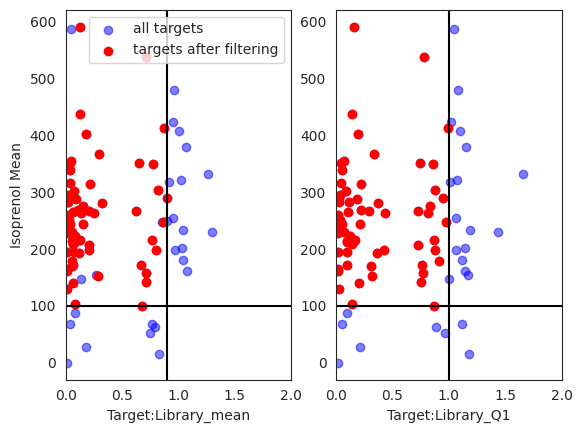

In [78]:
f = plot_filter_results(df_filtering, df_selection, 
                        [100, 100], [mean_thresh, q1_thresh],
                        ['Target:Library_mean', 'Target:Library_Q1'])
f.savefig(f"{user_params['output_dir']}/target_filter_results.png",
          transparent = True,
          bbox_inches = 'tight',
          dpi = 300,
         )

In [79]:
gene_targets= df_selection["Target"].tolist()
print(str(len(gene_targets))+ " gene targets:")
print(gene_targets)
print(f'Max isoprenol in df selection {max(df_selection["Isoprenol mean"])}')


67 gene targets:
['PP_4679', 'PP_0813', 'PP_4187', 'PP_4192', 'PP_1607', 'PP_4678', 'PP_1755', 'PP_2471', 'PP_0225', 'PP_4185', 'PP_4651', 'PP_1769', 'PP_4186', 'PP_2137', 'PP_1444', 'PP_4121', 'PP_1319', 'PP_0658', 'PP_0437', 'PP_0168', 'PP_4189', 'PP_4116', 'PP_0597', 'PP_4862', 'PP_4667', 'PP_5417', 'PP_1506', 'PP_4188', 'PP_4011', 'PP_2213', 'PP_0103', 'PP_3071', 'PP_2339', 'PP_1620', 'PP_0812', 'PP_3122', 'PP_0774', 'PP_4266', 'PP_0897', 'PP_0368', 'PP_5186', 'PP_4636', 'PP_3578', 'PP_4123', 'PP_3123', 'PP_2095', 'PP_3755', 'PP_5203', 'PP_1457', 'PP_4487', 'PP_0654', 'PP_1318', 'PP_4191', 'PP_5288', 'PP_0528', 'PP_4122', 'PP_2925', 'PP_0999', 'PP_0751', 'PP_3365', 'PP_3754', 'PP_2112', 'PP_0226', 'PP_4120', 'PP_4549', 'PP_1317', 'PP_2136']
Max isoprenol in df selection 590.5495666666667


In [80]:
user_params['n_instances_double'] = 25
user_params['n_instances_triple'] = 25
user_params['n_replicates'] = 3 
df_targets2 = df_selection[["Target","Isoprenol mean"]]
df_targets2.columns.name=''
df_targets2

,Target,Isoprenol mean
Strain,,
IY1671,PP_4679,100.588117
IY2188,PP_0813,401.706750
IY2057,PP_4187,215.706100
IY2211,PP_4192,349.035467
IY1452,PP_1607,289.814111
...,...,...
IY2207,PP_0226,209.453243
IY2026,PP_4120,242.994757
IY1586,PP_4549,302.681833


In [81]:
control_production = df_targets_norm.loc["NT",'Isoprenol mean']
df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production
df_targets2

/tmp/ipykernel_1052555/4108564400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2.loc[:,'Ratio'] = df_targets2.loc[:,'Isoprenol mean']/control_production


,Target,Isoprenol mean,Ratio
Strain,,,
IY1671,PP_4679,100.588117,0.395007
IY2188,PP_0813,401.706750,1.577494
IY2057,PP_4187,215.706100,0.847073
IY2211,PP_4192,349.035467,1.370655
IY1452,PP_1607,289.814111,1.138094
...,...,...,...
IY2207,PP_0226,209.453243,0.822518
IY2026,PP_4120,242.994757,0.954235
IY1586,PP_4549,302.681833,1.188625


As ratios go from very close to zero to around 1, we will add a factor (e.g. 5) to all of the targets so to have a non-zero probability to sample each of the targets.

In [82]:
df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)
df_targets2 = df_targets2.astype({'Weight': 'int'})
df_targets2

/tmp/ipykernel_1052555/2229913683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_targets2['Weight']= 5 + (10*df_targets2['Ratio']).apply(round)


,Target,Isoprenol mean,Ratio,Weight
Strain,,,,
IY1671,PP_4679,100.588117,0.395007,9
IY2188,PP_0813,401.706750,1.577494,21
IY2057,PP_4187,215.706100,0.847073,13
IY2211,PP_4192,349.035467,1.370655,19
IY1452,PP_1607,289.814111,1.138094,16
...,...,...,...,...
IY2207,PP_0226,209.453243,0.822518,13
IY2026,PP_4120,242.994757,0.954235,15
IY1586,PP_4549,302.681833,1.188625,17


And we get rid of the ratio, since we use the weight column to choose doubles and triples:

In [83]:
df_targets2 = df_targets2[['Target', 'Isoprenol mean','Weight']]
n_targets = len(df_targets2['Target'])
df_targets2.head()

,Target,Isoprenol mean,Weight
Strain,,,
IY1671,PP_4679,100.588117,9
IY2188,PP_0813,401.706750,21
IY2057,PP_4187,215.706100,13
IY2211,PP_4192,349.035467,19
IY1452,PP_1607,289.814111,16


### Check correlation between target selection and titer

Select a bunch of single targets (so that repeats don't affect picks) and plot their occurence vs. titer.

Text(0.5, 1.0, 'With weighting')

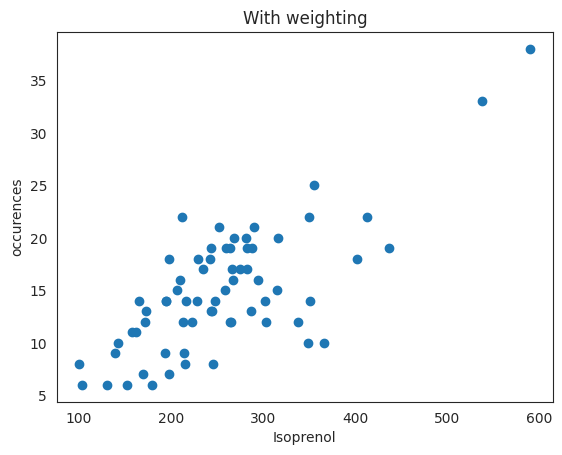

In [84]:
#Get random individual picks
targets_test = []
targets_test_nowt = []
for ii in range(1000):
    target_test = choose_targets(df_targets2, size = 1, weighting=True, n_instances=1)
    target_test_nowt = choose_targets(df_targets2, size = 1, weighting=False, n_instances=1)
    targets_test.append(target_test[0][0])
#Get unique
df_targets_test = df_targets2.copy()
df_targets_test['occurences'] = 0
count_occurences = lambda x: targets_test.count(x)
df_targets_test['occurences'] = df_targets_test['Target'].apply(count_occurences)
df_targets_test.head()
fig, ax = plt.subplots(1,1)
ax.scatter(df_targets_test['Isoprenol mean'], df_targets_test['occurences'])
plt.xlabel('Isoprenol')
plt.ylabel('occurences')
plt.title('With weighting')



In [85]:
list(np.unique(targets_test))

['PP_0103',
 'PP_0168',
 'PP_0225',
 'PP_0226',
 'PP_0368',
 'PP_0437',
 'PP_0528',
 'PP_0597',
 'PP_0654',
 'PP_0658',
 'PP_0751',
 'PP_0774',
 'PP_0812',
 'PP_0813',
 'PP_0897',
 'PP_0999',
 'PP_1317',
 'PP_1318',
 'PP_1319',
 'PP_1444',
 'PP_1457',
 'PP_1506',
 'PP_1607',
 'PP_1620',
 'PP_1755',
 'PP_1769',
 'PP_2095',
 'PP_2112',
 'PP_2136',
 'PP_2137',
 'PP_2213',
 'PP_2339',
 'PP_2471',
 'PP_2925',
 'PP_3071',
 'PP_3122',
 'PP_3123',
 'PP_3365',
 'PP_3578',
 'PP_3754',
 'PP_3755',
 'PP_4011',
 'PP_4116',
 'PP_4120',
 'PP_4121',
 'PP_4122',
 'PP_4123',
 'PP_4185',
 'PP_4186',
 'PP_4187',
 'PP_4188',
 'PP_4189',
 'PP_4191',
 'PP_4192',
 'PP_4266',
 'PP_4487',
 'PP_4549',
 'PP_4636',
 'PP_4651',
 'PP_4667',
 'PP_4678',
 'PP_4679',
 'PP_4862',
 'PP_5186',
 'PP_5203',
 'PP_5288',
 'PP_5417']

### Choose double targets

We now choose double targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

25
('PP_1607', 'PP_3755')
('PP_0528', 'PP_1506')
('PP_2137', 'PP_4651')
('PP_0658', 'PP_1506')
('PP_1319', 'PP_4122')
('PP_1506', 'PP_3578')
('PP_1755', 'PP_5203')
('PP_2213', 'PP_3123')
('PP_0897', 'PP_4186')
('PP_1317', 'PP_1444')
('PP_0812', 'PP_4487')
('PP_0437', 'PP_3365')
('PP_0999', 'PP_4185')
('PP_0368', 'PP_1317')
('PP_1457', 'PP_4188')
('PP_4862', 'PP_5288')
('PP_1318', 'PP_1506')
('PP_0897', 'PP_2137')
('PP_4266', 'PP_4636')
('PP_3755', 'PP_4192')
('PP_0528', 'PP_0897')
('PP_0226', 'PP_0437')
('PP_0168', 'PP_1769')
('PP_0813', 'PP_4122')
('PP_1318', 'PP_5186')


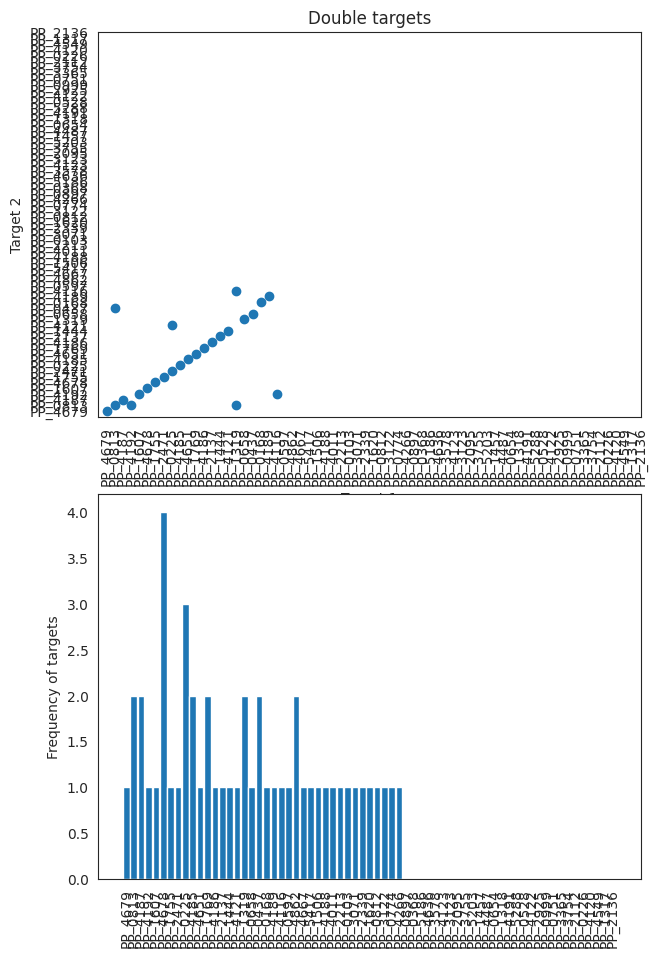

In [86]:
targets_double = choose_targets(
    df_targets2, 
    size=2, 
    n_instances= user_params['n_instances_double'],
    verbose=1
)

for target in targets_double:
    print(target)
    
#Save to file: 
with open(user_params['double_targets_file'], mode="wt") as f:
    for target in targets_double:
        f.write(str(target))
        
plot_double_targets(targets_double, df_targets2)


### Choose triple targets

As for the case of double targets, we choose triple targets randomly but increasing the chances of choosing strains with higher production (as given by the weight):

[('PP_3071', 'PP_4189', 'PP_5203'), ('PP_0226', 'PP_0597', 'PP_1620'), ('PP_1506', 'PP_1769', 'PP_5417'), ('PP_0654', 'PP_1755', 'PP_4191'), ('PP_0368', 'PP_4487', 'PP_4636'), ('PP_0897', 'PP_4651', 'PP_4667'), ('PP_1506', 'PP_1607', 'PP_4123'), ('PP_3071', 'PP_4120', 'PP_4121'), ('PP_3123', 'PP_4185', 'PP_4188'), ('PP_0226', 'PP_2925', 'PP_4191'), ('PP_0168', 'PP_3578', 'PP_3755'), ('PP_2471', 'PP_4123', 'PP_5417'), ('PP_1318', 'PP_1755', 'PP_4189'), ('PP_0368', 'PP_2136', 'PP_4186'), ('PP_1769', 'PP_3122', 'PP_4191'), ('PP_1444', 'PP_3755', 'PP_4667'), ('PP_1317', 'PP_4116', 'PP_4189'), ('PP_2339', 'PP_4189', 'PP_4192'), ('PP_0812', 'PP_0999', 'PP_4651'), ('PP_1506', 'PP_1607', 'PP_4185'), ('PP_0999', 'PP_1769', 'PP_4189'), ('PP_2136', 'PP_4186', 'PP_4678'), ('PP_0103', 'PP_0813', 'PP_5203'), ('PP_0368', 'PP_3365', 'PP_4187'), ('PP_0812', 'PP_4487', 'PP_5186')]


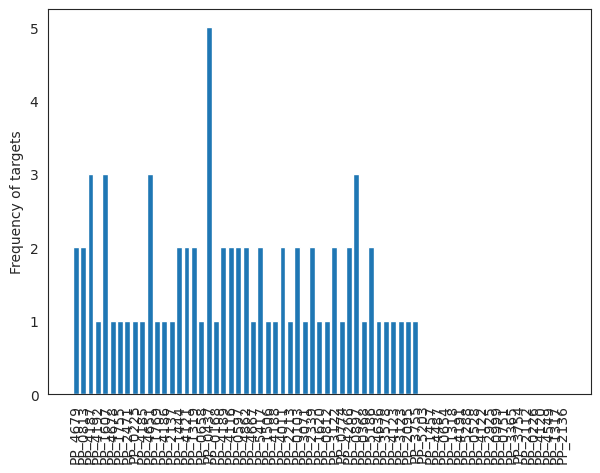

In [87]:
targets_triple = choose_targets(
    df_targets2, 
    size=3, 
    n_instances=user_params['n_instances_triple'], 
)

print(targets_triple)

plot_triple_targets(targets_triple, df_targets2)

with open(user_params['triple_targets_file'], mode="wt") as f:
    for target in targets_triple:
        f.write(str(target))

## Visualize recommendations:
Make violin plots of the most common recommendations and all of the potential recommendations.


(<Figure size 1500x1500 with 20 Axes>,
 Formal Type   PP_0001   PP_0103   PP_0168    PP_0225   PP_0226   PP_0338  \
 Strain                                                                     
 IY1688       0.739278       NaN  0.825983   2.003226  1.584326  0.938763   
 IY2020       1.110978       NaN  1.308244   8.994774  0.844410  1.140929   
 IY2212       0.889621  1.553079  4.056849   1.553079  0.121210  0.794977   
 IY2036       0.876993  2.079442  2.162881   0.412686  0.032208  1.135606   
 IY1596       0.624799       NaN  2.148304        NaN  1.268535  0.992616   
 ...               ...       ...       ...        ...       ...       ...   
 IY2224       1.362559  0.974642  2.615471  39.917396  0.423043  0.851244   
 IY2025       1.357689  1.763963  2.837179   1.763963  0.596886  1.002674   
 IY2192       1.240413  0.839857  1.470351   2.174464  0.065546  0.578098   
 IY1673       0.662708       NaN  0.292840   4.594720  1.211545  1.324996   
 IY1661       0.764220       NaN  1.4

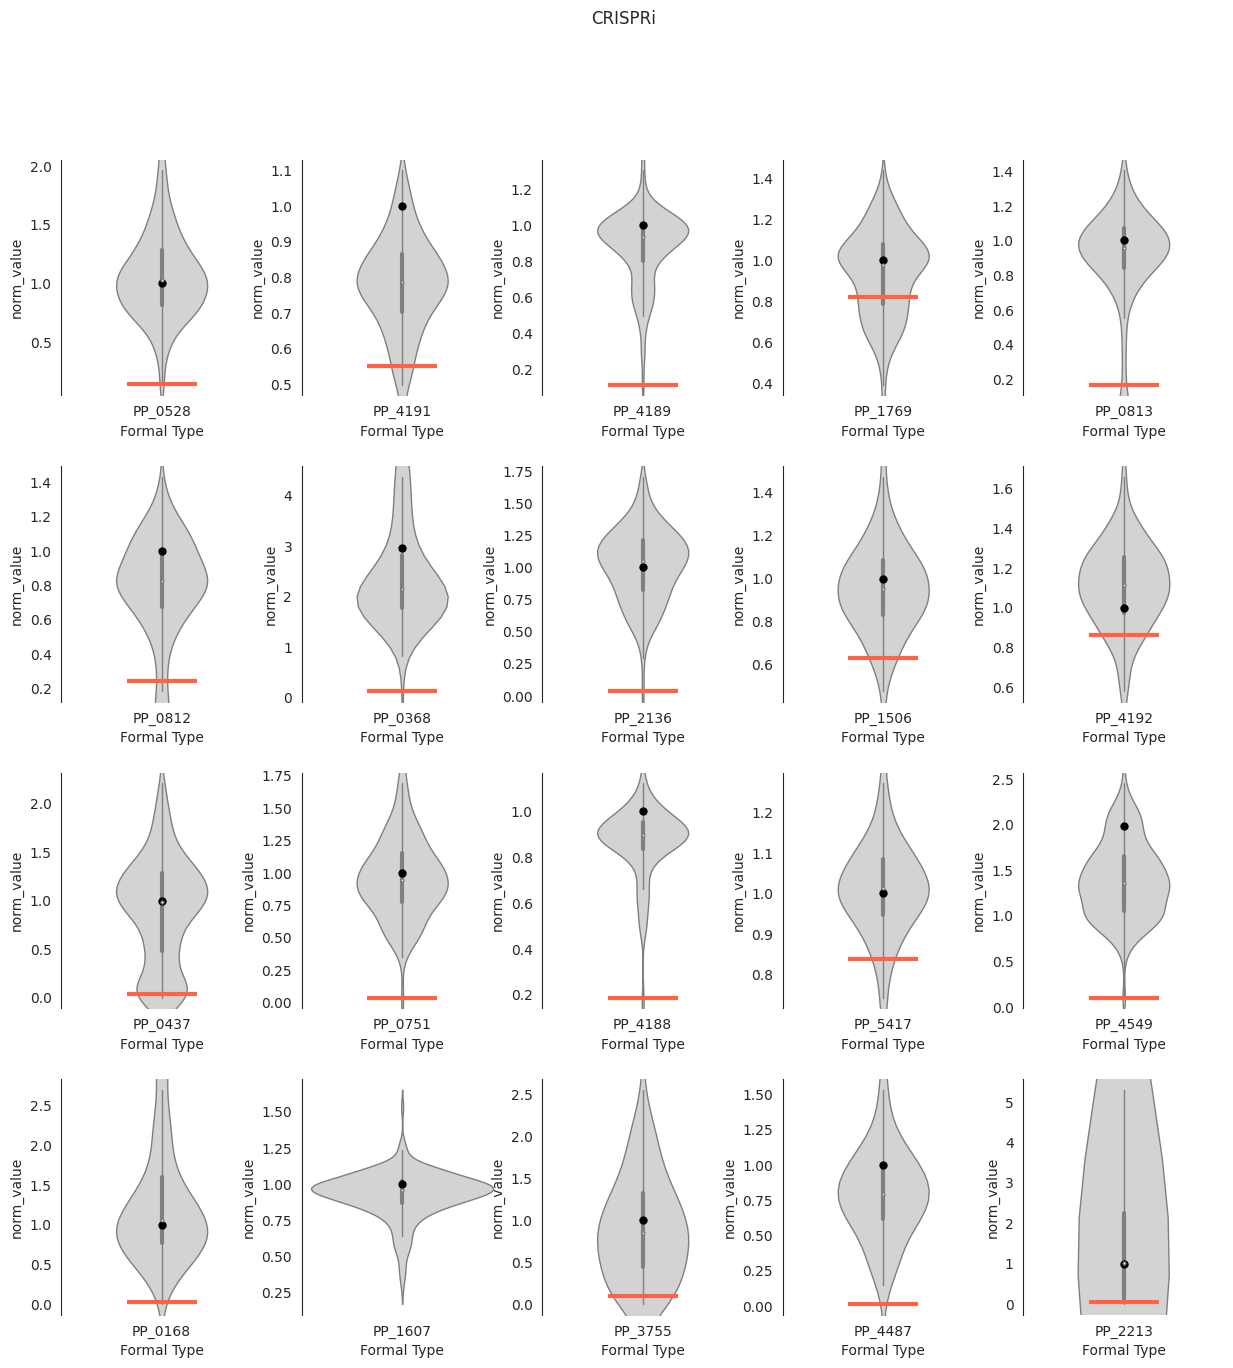

In [97]:
sorted_filtered_targets = df_targets2.loc[:, ['Isoprenol mean', 'Target']].dropna().sort_values('Isoprenol mean', ascending = False)
high_producers = list(sorted_filtered_targets.loc[:, 'Target'].values[:20])
#Alter the save_name so that we don't overwrite the other image
save_name_highprod = f"{user_params['output_dir']}/crispri_high_producers.png"
plot_crispr_library(df_norm, df_targets_norm, high_producers, save = True, violin_field = 'norm_value', save_name = save_name_highprod)
